In [1]:
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
from esn.esn import ESN
import jax
import jax.numpy as jnp
from functools import partial
from ddpg_experiment_v3 import draw_initial_condition, plot_KS_episode
from utils import covariance_matrix as cov
import ml_collections
from utils import preprocessing as pp
from utils.mode_decomposition import POD
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_episode(config, env, episode_type='null_action'):
    # create a action of zeros to pass
    null_action = jnp.zeros(env.action_size)

    # jit the necessary environment functions
    env_draw_initial_condition = partial(
        draw_initial_condition,
        std_init=config.enKF.std_init,
    )
    env_draw_initial_condition = jax.jit(env_draw_initial_condition)

    env_reset = partial(
        KSenv.reset,
        N=env.N,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        initial_amplitude=env.initial_amplitude,
        action_size=env.action_size,
        burn_in=env.burn_in,
        observation_inds=env.observation_inds,
    )

    env_reset = jax.jit(env_reset)
    env_step = partial(
        KSenv.step,
        frame_skip=env.frame_skip,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        target=env.target,
        actuator_loss_weight=env.actuator_loss_weight,
        termination_threshold=env.termination_threshold,
        observation_inds=env.observation_inds,
    )
    env_step = jax.jit(env_step)
    env_sample_action = partial(
        KSenv.sample_continuous_space,
        low=env.action_low,
        high=env.action_high,
        shape=(env.action_size,),
    )
    env_sample_action = jax.jit(env_sample_action)

    def until_first_observation(true_state, true_obs, observation_starts):
        def body_fun(carry, _):
            true_state, true_obs = carry
            # advance true environment
            action = null_action
            true_state, true_obs, reward, _, _, _ = env_step(
                state=true_state, action=action
            )
            return (true_state, true_obs), (true_state, true_obs, action, reward)

        (true_state, true_obs), (
            true_state_arr,
            true_obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs), jnp.arange(observation_starts)
        )
        return (
            true_state,
            true_obs,
            true_state_arr,
            true_obs_arr,
            action_arr,
            reward_arr,
        )
    
    def null_action_observe_and_forecast(
        true_state,
        true_obs,
        wait_steps,
        episode_steps,
        key_obs,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs = carry

            # get action
            action = null_action

            # get the next observation and reward with this action
            true_state, true_obs, reward, _, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs), (
                true_state,
                true_obs,
                action,
                reward,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, key_obs = carry

            obs_cov = cov.get_max(std=config.enKF.std_obs, y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            (true_state, true_obs), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
            ) = jax.lax.scan(
                forecast_fun, (true_state, true_obs), jnp.arange(wait_steps)
            )
            return (true_state, true_obs, key_obs), (
                true_state_arr,
                true_obs_arr,
                obs,
                action_arr,
                reward_arr,
            )

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, key_obs), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs, key_obs), jnp.arange(n_loops)
        )
        return (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        )
    
    def random_observe_and_forecast(
        true_state,
        true_obs,
        wait_steps,
        episode_steps,
        key_obs,
        key_action,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, action = carry

            # get the next observation and reward with this action
            true_state, true_obs, reward, terminated, _, _ = env_step(
                state=true_state, action=action
            )

            return (true_state, true_obs, action), (
                true_state,
                true_obs,
                action,
                reward,
                terminated,
            )

        def body_fun(carry, _):
            # observe
            # we got an observation
            true_state, true_obs, key_obs, key_action = carry

            # get action
            key_action, _ = jax.random.split(key_action)
            action = env_sample_action(key=key_action)

            obs_cov = cov.get_max(std=config.enKF.std_obs, y=true_obs)

            # add noise on the observation
            key_obs, _ = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            # propagate environment with the given action
            (true_state, true_obs, action), (
                true_state_arr,
                true_obs_arr,
                action_arr,
                reward_arr,
                terminated_arr,
            ) = jax.lax.scan(
                forecast_fun,
                (true_state, true_obs, action),
                jnp.arange(wait_steps),
            )
            
            return (
                true_state,
                true_obs,
                key_obs,
                key_action,
            ), (true_state_arr, true_obs_arr, obs, action_arr, reward_arr)

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, key_obs, key_action), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun,
            (true_state, true_obs, key_obs, key_action),
            jnp.arange(n_loops),
        )
        return (
            true_state,
            true_obs,
            key_obs,
            key_action,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
        )

    until_first_observation = partial(
        until_first_observation,
        observation_starts=config.enKF.observation_starts,
    )
    until_first_observation = jax.jit(until_first_observation)

    null_action_observe_and_forecast = partial(
        null_action_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    null_action_observe_and_forecast = jax.jit(null_action_observe_and_forecast)

    random_observe_and_forecast = partial(
        random_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    random_observe_and_forecast = jax.jit(random_observe_and_forecast)
    def episode(key_env, key_obs, key_action):
        # reset the environment
        key_env, key_init = jax.random.split(key_env, 2)
        init_true_state_mean, _, _ = env_reset(key=key_env)
        init_true_state = env_draw_initial_condition(u0=init_true_state_mean, key=key_init)
        init_true_obs = init_true_state[env.observation_inds]

        init_reward = jnp.nan

        # forecast until first observation
        (
            true_state,
            true_obs,
            true_state_arr0,
            true_obs_arr0,
            action_arr0,
            reward_arr0,
        ) = until_first_observation(
            true_state=init_true_state, true_obs=init_true_obs
        )

        if episode_type == 'null_action':
            (
            true_state,
            true_obs,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            action_arr,
            reward_arr,
            ) = null_action_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                key_obs=key_obs,
            ) 
        elif episode_type == 'random_action':
            # add noise on the observation
            (
                true_state,
                true_obs,
                key_obs,
                key_action,
                true_state_arr,
                true_obs_arr,
                obs_arr,
                action_arr,
                reward_arr,
            ) = random_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                key_obs=key_obs,
                key_action=key_action,
            )

        true_state_arr = jnp.reshape(
            true_state_arr,
            (
                true_state_arr.shape[0] * true_state_arr.shape[1],
                true_state_arr.shape[2],
            ),
        )
        true_obs_arr = jnp.reshape(
            true_obs_arr,
            (true_obs_arr.shape[0] * true_obs_arr.shape[1], true_obs_arr.shape[2]),
        )
        action_arr = jnp.reshape(
            action_arr,
            (action_arr.shape[0] * action_arr.shape[1], action_arr.shape[2]),
        )

        reward_arr = jnp.reshape(
            reward_arr,
            (reward_arr.shape[0] * reward_arr.shape[1],),
        )
        stack = lambda a, b, c: jnp.vstack((jnp.expand_dims(a, axis=0), b, c))
        hstack = lambda a, b, c: jnp.hstack((jnp.expand_dims(a, axis=0), b, c))

        return (
            stack(init_true_state, true_state_arr0, true_state_arr),
            stack(init_true_obs, true_obs_arr0, true_obs_arr),
            obs_arr,
            stack(null_action, action_arr0, action_arr),
            hstack(init_reward, reward_arr0, reward_arr),
            key_env,
            key_obs,
            key_action,
        )
    
    return episode       

In [3]:
config = ml_collections.ConfigDict()
config.env = ml_collections.ConfigDict()
config.env.N = 64
L = 22
nu = (2 * jnp.pi / L)**2
config.env.nu = 0.08
config.env.actuator_scale = 0.1
config.env.actuator_loss_weight = 1.0
config.env.burn_in = 1000
config.env.actuator_locs = ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.sensor_locs = ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.target = "e0"
config.env.frame_skip = 1

config.seed = 41
config.episode_steps = 1000

config.enKF = ml_collections.ConfigDict()
config.enKF.std_init = 0.0
config.enKF.m = 0
config.enKF.std_obs = 0.0
config.enKF.low_order_N = 0
config.enKF.observation_starts = 0
config.enKF.wait_steps = 1

In [4]:
# create environment
env = KSenv(**config.env)

In [5]:
seed = 0
episode_type = 'random_action'
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4) 
episode = generate_episode(config, env, episode_type=episode_type)

In [6]:
total_episodes = 55
RAW_DATA = {'true_state':[],'true_observation':[],'observation':[],'action':[],'pod_time_coeff':[]}
# for i in range(total_episodes):
#     (
#         true_state_arr,
#         true_obs_arr,
#         obs_arr,
#         action_arr,
#         reward_arr,
#         key_env,
#         key_obs,
#         key_action
#     ) =  episode(key_env, key_obs, key_action)
#     # fig = plot_KS_episode(
#     #     env,
#     #     true_state_arr,
#     #     true_obs_arr,
#     #     obs_arr,
#     #     action_arr,
#     #     reward_arr,
#     #     config.enKF.wait_steps,
#     #     config.enKF.observation_starts,
#     # )
#     RAW_DATA['true_state'].append(true_state_arr)
#     RAW_DATA['true_observation'].append(true_obs_arr)
#     RAW_DATA['observation'].append(obs_arr)
#     RAW_DATA['action'].append(action_arr)


# Define batched random keys for parallel processing
key_env, subkey_env = jax.random.split(key_env)
key_obs, subkey_obs = jax.random.split(key_obs)
key_action, subkey_action = jax.random.split(key_action)

# Create batched keys for all episodes
batch_keys_env = jax.random.split(subkey_env, total_episodes)
batch_keys_obs = jax.random.split(subkey_obs, total_episodes)
batch_keys_action = jax.random.split(subkey_action, total_episodes)

# Use vmap to process all episodes in parallel
batched_results = jax.vmap(episode)(
    batch_keys_env,
    batch_keys_obs,
    batch_keys_action
)

# Unpack results
(
    true_state_arrs,
    true_obs_arrs,
    obs_arrs,
    action_arrs,
    reward_arrs,
    _, _, _  # Keys can be ignored if not needed further
) = batched_results

RAW_DATA['true_state'] = true_state_arrs
RAW_DATA['true_observation'] = true_obs_arrs
RAW_DATA['observation'] = obs_arrs
RAW_DATA['action'] = action_arrs

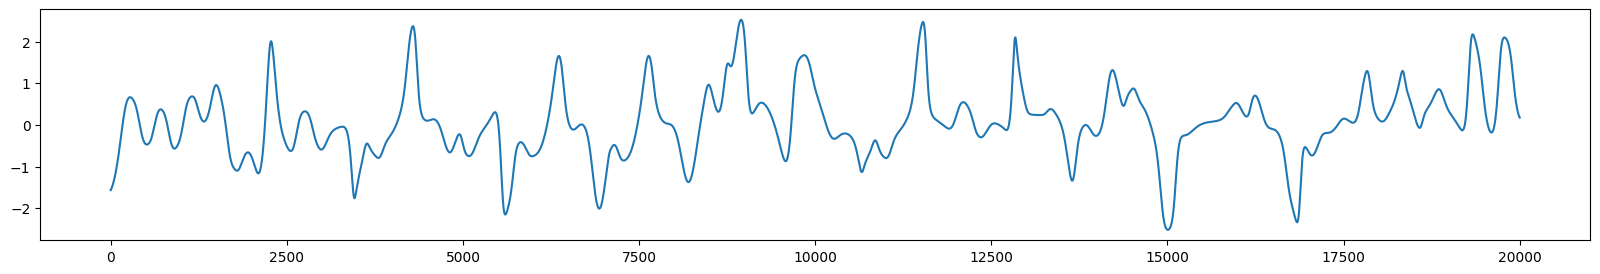

In [99]:
plt.figure(figsize=(20,3))
plt.plot(RAW_DATA['true_state'][0][:,0])

In [8]:
# avgs = []
# for i in range(total_episodes):
#     avgs.append(np.cumsum(RAW_DATA['true_state'][i],axis=0)/np.arange(1,len(RAW_DATA['true_state'][i])+1)[:,None])
#     plt.plot(avgs[i])

In [9]:
# means = []
# cutoff_step = 100000
# mean_step = 10000
# n_means = int(len(RAW_DATA['true_state'][0]) // mean_step)
# for i in range(n_means):
#     means.append(jnp.mean(RAW_DATA['true_state'][0][cutoff_step:(i+1)*mean_step,:],axis=0))

In [10]:
# for i in range(n_means-2,n_means):
#     plt.plot(means[i])

In [11]:
# means = []
# cutoff_step = 1000
# mean_step = 300000
# n_means = int((len(RAW_DATA['true_state'][0])-mean_step) // cutoff_step)
# for i in range(n_means):
#     means.append(jnp.mean(RAW_DATA['true_state'][0][i*cutoff_step:i*cutoff_step+mean_step,:],axis=0))

In [12]:
# for i in range(n_means-10,n_means):
#     plt.plot(means[i])

In [13]:
# from scipy.signal import correlate
# corr = correlate(RAW_DATA['true_state'][0][:,0],RAW_DATA['true_state'][0][:,0])

In [14]:
# plt.plot(corr)

In [15]:
# import h5py
# ks_data = {
#     'upsample': 1,
#     'L': 22,
#     'N_data': 200000,
#     'N_trans': 1000,
#     'dt': 0.05,
#     'Nx': 128,
#     'Nu': 1,
#     # 'fln': '',
#     'train_ratio': 0.25,
#     'valid_ratio': 0.05,
#     'b_size': 128,
#     'normtype': 'max'
# }
# f = h5py.File('/storage0/eo821/KS/L22/M128_N256_tmax10000_deltat0.05L22.mat','r')

# data = f.get('uu')

# U = np.array(data)[:, ks_data['N_trans']:ks_data['N_data']:ks_data['upsample']].T # For converting to a NumPy array

# RAW_DATA2 = {'true_state':[],'true_observation':[],'observation':[],'action':[],'pod_time_coeff':[]}
# RAW_DATA2['true_state'] = [U]
# RAW_DATA2['true_observation'] = [U]
# RAW_DATA2['observation'] = [U]
# RAW_DATA2['action'] = np.zeros((env.action_size, len(U)))

In [8]:
pod_episodes = 50

def get_POD_time_coeffs(my_POD,y):
    return (y-my_POD.Q_mean) @ my_POD.Phi

# apply POD
stacked_state_arr = jnp.vstack(RAW_DATA['true_state'][:pod_episodes])
my_POD = POD(X=stacked_state_arr.T)
all_time_coeffs = my_POD.get_time_coefficient
for i in range(total_episodes):
    RAW_DATA['pod_time_coeff'].append(get_POD_time_coeffs(my_POD, RAW_DATA['true_state'][i]))

cum_energy = np.cumsum(my_POD.lam)/np.sum(my_POD.lam)

Calculating POD ...
Use classic POD, Nx <= Nt.
POD done.
Returning temporal coefficients for classic POD.


/home/do521/DA-RL/utils/mode_decomposition.py:230: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD * self.w).real ** 0.5


In [9]:
RAW_DATA['forcing'] = []
for i in range(total_episodes):
    RAW_DATA['forcing'].append((env.ks_solver.B @ RAW_DATA["action"][0].T).T)

IndexError: index -100000 is out of bounds for axis 0 with size 50050

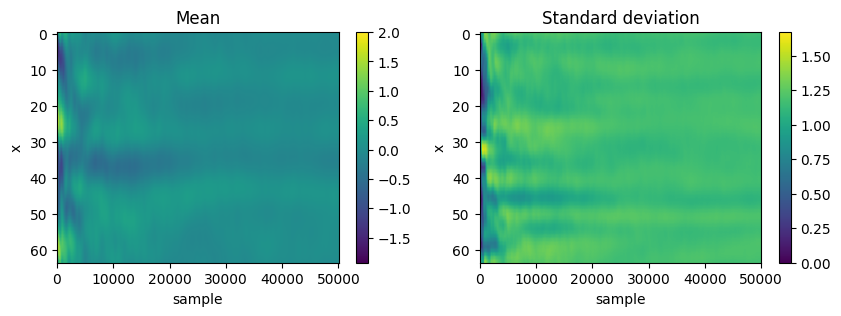

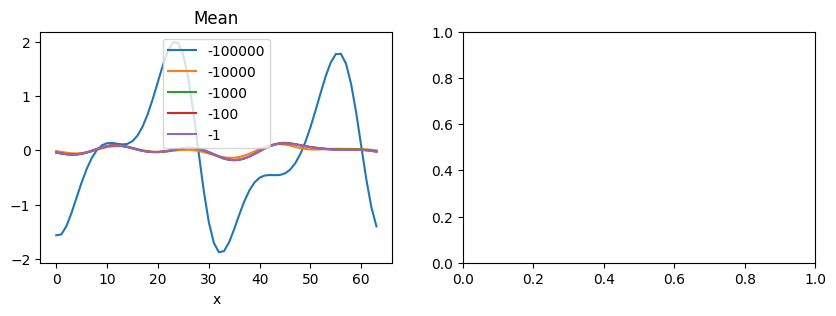

In [10]:
# Check convergence of the statistics
cumsum = np.cumsum(stacked_state_arr, axis=0)
cumsum_sq = np.cumsum(stacked_state_arr**2, axis=0)
n = np.arange(1, len(stacked_state_arr) + 1)[:, None]  # Shape (len, 1)

mean = cumsum / n
mean_sq = cumsum_sq / n

std = np.sqrt(mean_sq - mean**2)

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(mean.T, aspect='auto')
plt.xlabel('sample')
plt.ylabel('x')
plt.title('Mean')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(std.T, aspect='auto')
plt.xlabel('sample')
plt.ylabel('x')
plt.title('Standard deviation')
plt.colorbar()

plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
idxs = [-100000,-10000,-1000,-100,-1]
for i in idxs:
    plt.plot(mean[i], label=i)
plt.legend()
plt.xlabel('x')
plt.title('Mean')
plt.subplot(1,2,2)
for i in idxs:
    plt.plot(std[i], label=i)
plt.legend()
plt.xlabel('x')
plt.title('Standard deviation')

Which modes = 10


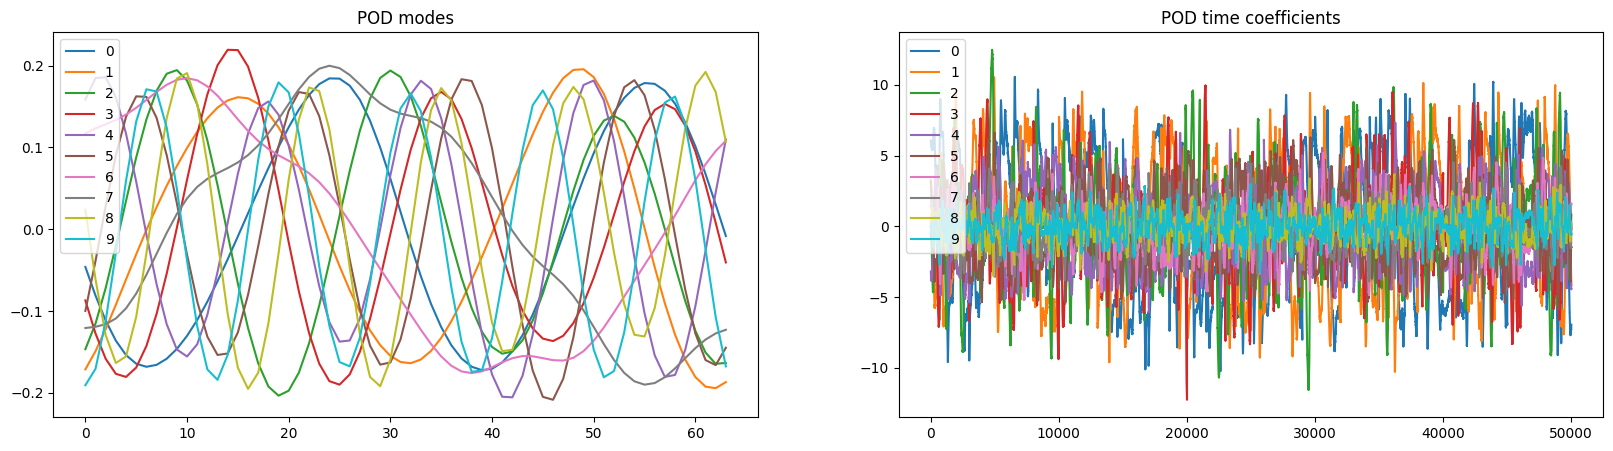

In [13]:
pod_modes = my_POD.get_modes[0]
which_modes = int(np.where(cum_energy>0.99)[0][0])
which_modes = which_modes + (which_modes % 2) # round it to the next even number
print(f'Which modes = {which_modes}')
plot_mode = list(np.arange(0,which_modes))
# plot_mode = list(np.arange(20,30))
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(pod_modes[:,plot_mode])
plt.title('POD modes')
plt.legend(plot_mode)
plt.subplot(1,2,2)
plt.plot(all_time_coeffs[:,plot_mode])
plt.title('POD time coefficients')
plt.legend(plot_mode)

In [14]:
a = get_POD_time_coeffs(my_POD, RAW_DATA['forcing'][0])

In [15]:
recon_forcing = my_POD.reconstruct(which_modes=which_modes, A=a).T

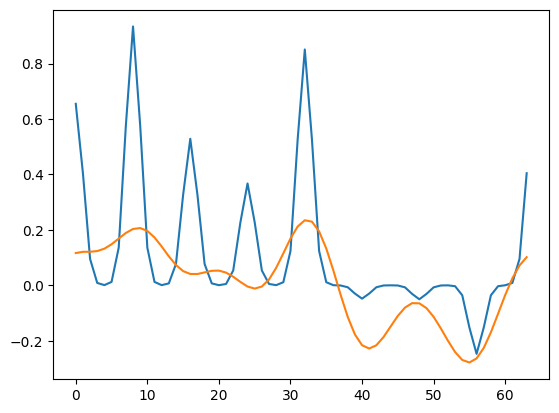

In [16]:
idx = 600
plt.plot(RAW_DATA['forcing'][0][idx,:])
plt.plot(recon_forcing[idx,:])

In [17]:
which_state = 'true_state'
which_modes = (np.where(cum_energy>0.99)[0][0])
which_modes = int(which_modes + (which_modes % 2)) # round it to the next even number
print(f'Which modes = {which_modes}')

train_episodes = 45
val_episodes = 5
test_episodes = 5

train_idxs = np.arange(train_episodes)
val_idxs = np.arange(train_episodes, train_episodes+val_episodes)
test_idxs = np.arange(pod_episodes, pod_episodes+test_episodes) 
idxs_list = np.concatenate((train_idxs,val_idxs,test_idxs), axis=None)

config.episode_steps = 1000
total_time = env.dt * config.episode_steps
washout_time = 5
train_time = total_time - washout_time
# train_time = 2000
# validation_time = 0.2 * total_time
network_dt = env.dt
t = env.dt * jnp.arange(config.episode_steps+1)

loop_names=['train']
loop_times = [train_time]
DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'full_state':[],'t':[]}

for i in idxs_list:
    if which_state == 'pod_time_coeff':
        y = RAW_DATA[which_state][i][:,:which_modes] 
        # a = get_POD_time_coeffs(my_POD, RAW_DATA['forcing'][i][1:])[:,:which_modes]
        a = RAW_DATA['action'][i][1:]
    else:
        y = RAW_DATA[which_state][i]
        a = RAW_DATA['action'][i][1:]

    full_state = RAW_DATA['true_state'][i]

    episode_data = pp.create_dataset(full_state,y,t,a,
                                    network_dt,
                                    transient_time=0,
                                    washout_time=washout_time,
                                    loop_times=loop_times,
                                    loop_names=loop_names,
                                    )
    for loop_name in loop_names:
        [DATA[loop_name][var].append(np.asarray(episode_data[loop_name][var])) for var in DATA[loop_name].keys()]
        # convert to numpy here because ESN is in numpy

# new idxs
train_idxs = np.arange(train_episodes)
val_idxs = np.arange(train_episodes, train_episodes+val_episodes)
test_idxs = np.arange(train_episodes+val_episodes, train_episodes+val_episodes+test_episodes) 

Which modes = 10


In [20]:
# plt.figure(figsize=(20,5))
# plt.imshow(RAW_DATA['true_state'][0].T, aspect='auto')
# plt.figure(figsize=(20,5))
# plt.imshow(RAW_DATA2['true_state'][0][:40000,:].T, aspect='auto')

In [18]:
data_mean = np.mean(np.vstack(DATA["train"]["u"]), axis = 0)
data_std = np.std(np.vstack(DATA["train"]["u"]), axis = 0)
parameter_mean = np.mean(np.vstack(DATA["train"]["p"]), axis=0)
parameter_std = np.std(np.vstack(DATA["train"]["p"]), axis=0)

In [ ]:
# for i in range(len(DATA["train"]["p"])):
#     DATA["train"]["p"][i] = (DATA["train"]["p"][i]-parameter_mean) / parameter_std

In [19]:
if episode_type == 'null_action':
    parameter_dimension = 0
elif episode_type == 'random_action':
    if which_state == 'pod_time_coeff':
        # parameter_dimension = which_modes
        parameter_dimension = env.action_size
    else:
        parameter_dimension = env.action_size

ESN_dict = {
        "reservoir_size": 3000,
        "parameter_dimension": parameter_dimension,
        "reservoir_connectivity": 3,
        "r2_mode": True,
        "input_only_mode": False,
        "input_weights_mode": 'sparse_grouped_parameter',
        "reservoir_weights_mode": 'erdos_renyi1',
        "tikhonov": 1e-7,
        "dimension": DATA['train']['u'][0].shape[1],
        "output_bias": np.array([1.0]),
        # "input_bias": np.array([1.0]),
        "input_normalization": [data_mean, data_std],
        "spectral_radius": 0.54523636,
        "input_scaling": 0.0279345,
        "leak_factor": 1.0,
    }

ESN_dict['input_seeds'] = [0,1,2]
ESN_dict['reservoir_seeds'] = [3,4]

my_ESN = ESN(**ESN_dict)
# my_ESN.train(DATA["train"]["u_washout"], 
#              DATA["train"]["u"], 
#              DATA["train"]["y"],
#              DATA["train"]["p_washout"], 
#              DATA["train"]["p"],
#              train_idx_list=train_idxs 
#             )
# in jax esn parallelize training when we give a list of u

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [ ]:
# project actions onto pod basis

In [103]:
from esn.validation import validate
from esn.utils import errors,scalers

# range for hyperparameters 
spec_in     = 0.1
spec_end    = 1.0
in_scal_in  = 0.01
in_scal_end = 10.0
leak_in     = 0.1    
leak_end    = 1.0
tikh_in = 1e-8
tikh_end = 1e-1
param_var_in = 0.01 
param_var_end = 10.0

# hyperparameter names, should match the attributes of ESN
if episode_type == 'null_action':
    hyp_param_names = ['input_scaling','spectral_radius','leak_factor','tikhonov']
    grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [tikh_in, tikh_end],
              ]
    # scales, uniform or log10
    hyp_param_scales = ['log10','log10','uniform','log10']
elif episode_type == 'random_action':
    hyp_param_names = ['input_scaling','spectral_radius','leak_factor','tikhonov','parameter_normalization_var']
    grid_range = [[in_scal_in, in_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [tikh_in, tikh_end],
              [param_var_in, param_var_end],
              ]
    # scales, uniform or log10
    hyp_param_scales = ['log10','log10','uniform','log10','log10']


# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
N_washout = int(np.round(washout_time/network_dt))
fold_time = 25
N_val = int(np.round(fold_time/network_dt))
N_transient = 0
min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 10, n_initial_points = 5,
    ESN_dict = ESN_dict,
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["train"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["train"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["train"]["p"],
    n_folds = 3,
    n_realisations= 1,
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = N_transient,
    n_grid = None,
    error_measure=errors.rel_L2,
    train_idx_list=train_idxs,
    val_idx_list=val_idxs)

--NEW RUN-- 1
Realisation: 0
input_scaling 0.07875596470213515
spectral_radius 0.3123129046861073
leak_factor 0.49871345291974767
tikhonov 0.01


Val regime: 0
Val regime error: 6.885874226869665
Val regime: 1
Val regime error: 5.5410823553488
Val regime: 2
Val regime error: 6.5773863084145185
Val regime: 3
Val regime error: 5.625327147140065
Val regime: 4
Val regime error: 7.15553890256486
Realisation error: 6.357041788067582


Run 1 error: 6.357041788067582
Error: 6.357041788067582


--NEW RUN-- 2
Realisation: 0
input_scaling 0.562296280607296
spectral_radius 0.10596726573597295
leak_factor 0.7382872088587109
tikhonov 1e-06


Val regime: 0
Val regime error: 3.778106239232797
Val regime: 1
Val regime error: 4.049542650855373
Val regime: 2
Val regime error: 3.4155114699140956
Val regime: 3
Val regime error: 3.6180889341134965
Val regime: 4
Val regime error: 4.010547229101301
Realisation error: 3.7743593046434127


Run 2 error: 3.7743593046434127
Error: 3.7743593046434127


--NEW RUN-- 

KeyboardInterrupt: 

In [261]:
min_dict 

{'f': array([0.0074888 , 0.02103785, 0.0289201 , 0.04085313, 0.04738712]),
 'spectral_radius': array([0.36747762, 0.51192697, 0.69541466, 0.49756602, 0.24779285]),
 'leak_factor': array([0.46998663, 0.33900951, 0.21284915, 0.33154568, 0.74788235]),
 'input_scaling': array([0.05457228, 0.01189913, 0.1096871 , 0.01      , 0.01000015]),
 'tikhonov': array([1.e-06, 1.e-06, 1.e-06, 1.e-06, 1.e-06]),
 'parameter_normalization_var': array([0.03147388, 0.02825749, 0.03121764, 0.02761018, 0.03145255])}

In [359]:
min_dict 

{'f': array([0.04370772, 0.30136872, 0.32320063, 0.46373573, 0.57318721]),
 'spectral_radius': array([0.51192697, 0.60079846, 0.3123129 , 0.75442303, 0.92935889]),
 'leak_factor': array([0.33900951, 0.62551123, 0.49871345, 0.75469196, 0.29681837]),
 'input_scaling': array([0.01189913, 0.17418154, 0.07875596, 0.01235521, 0.01355128]),
 'tikhonov': array([1.e-06, 1.e-07, 1.e-02, 1.e-04, 1.e-05]),
 'parameter_normalization_var': array([0.02825749, 3.00778468, 0.56229628, 0.02479559, 0.01055228])}

In [ ]:
# try using the POD modes from not actuated case?

In [20]:
# normalized
# full state, N = 64, n_actuators = 1
min_dict = {'spectral_radius':[0.60079846],
            'input_scaling' : [0.17418154],
            'tikhonov' : [1.e-07],
            'leak_factor' : [0.62551123],
            'parameter_normalization_var' : [3.00778468],
            }

# full state, N = 256, n_actuators = 1
# min_dict = {'spectral_radius':[0.28103602],
#             'input_scaling' : [0.04671615],
#             'tikhonov' : [1.e-02],
#             'leak_factor' : [0.50032329],
#             'parameter_normalization_var' : [0.7955933],
#             }

# full state, N = 256, n_actuators = 8, actuator_scale = 0.1, f = 0.007
# min_dict = {'spectral_radius':[0.36],
#             'input_scaling' : [0.054],
#             'tikhonov' : [1.e-06],
#             'leak_factor' : [0.46],
#             'parameter_normalization_var' : [0.031],
#             }

# pod, N = 10, n_actuators = 1
# because normalized the thing that matters the most is the input scaling
# then leak factor! if 0.5 then the frequency spectrum doesn't look right
# min_dict = {'spectral_radius':[0.28],
#             'input_scaling' : [0.49],
#             'tikhonov' : [1.e-02],
#             'leak_factor' : [1.0],
#             'parameter_normalization_var' : [0.79],
#             }

In [21]:
best_idx = 0
ESN_dict['spectral_radius'] = min_dict["spectral_radius"][best_idx]
ESN_dict['input_scaling'] = min_dict["input_scaling"][best_idx]
ESN_dict['leak_factor'] = min_dict["leak_factor"][best_idx]
ESN_dict['tikhonov'] = min_dict["tikhonov"][best_idx]

my_ESN = ESN(**ESN_dict)
if parameter_dimension > 0:
    my_ESN.parameter_normalization_var = min_dict["parameter_normalization_var"][best_idx]
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             DATA["train"]["p_washout"], 
             DATA["train"]["p"],
             train_idx_list=train_idxs 
            )

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.
Parameter normalization is changed, training must be done again.


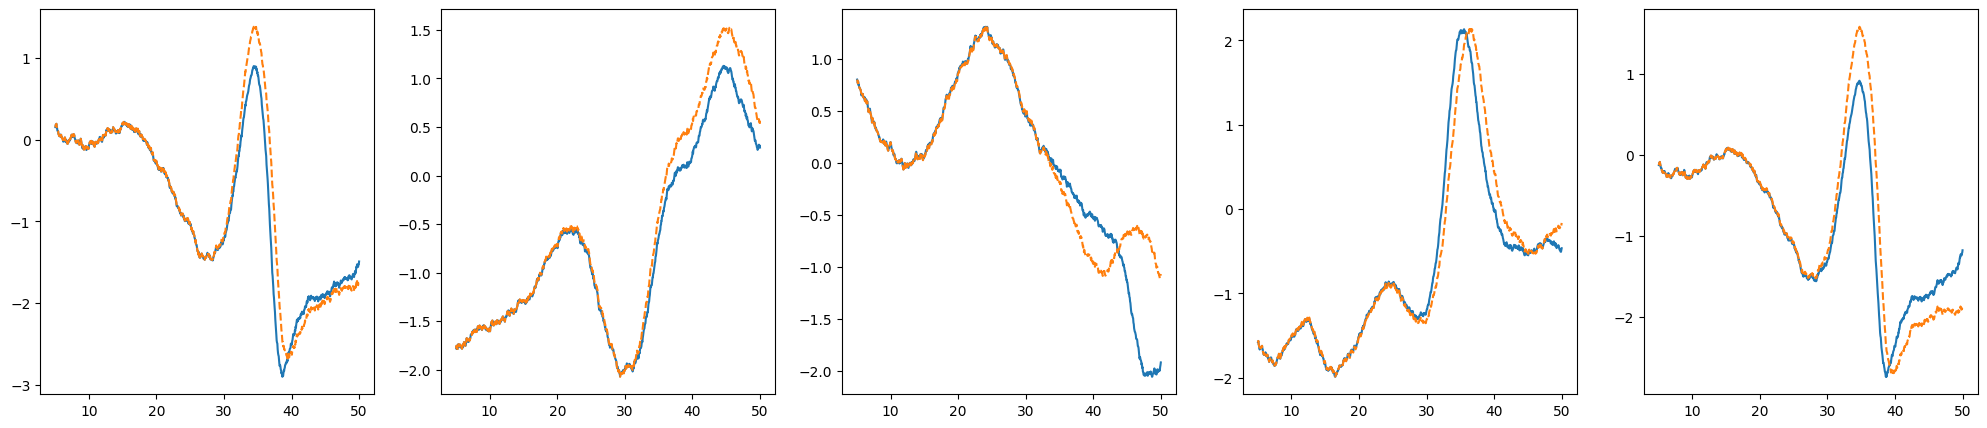

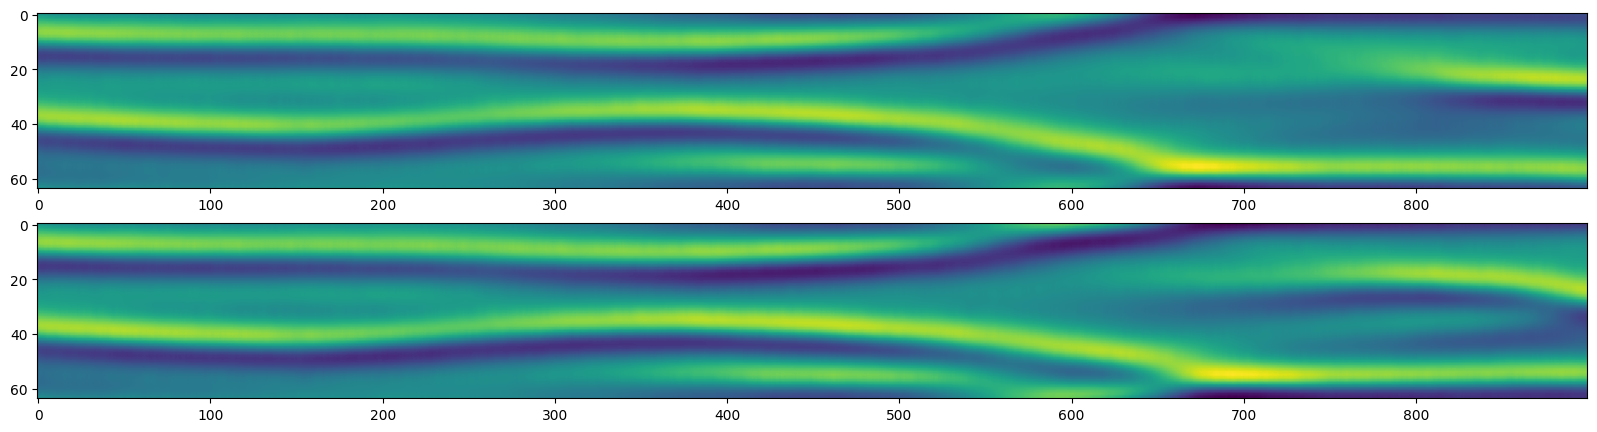

In [24]:
episode_idx = test_idxs[0]
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=DATA['train']['u_washout'][episode_idx], 
                                                 P_washout=DATA['train']['p_washout'][episode_idx],
                                                 P = DATA['train']['p'][episode_idx],
                                                 N_t=len(DATA['train']['u'][episode_idx]))
y_pred = y_pred[1:]
plt_idxs = [int(my_idx) for my_idx in np.linspace(0,my_ESN.N_dim-1,5)]
plt.figure(figsize=(5*len(plt_idxs),5))
for k, plt_idx in enumerate(plt_idxs):
    plt.subplot(1,len(plt_idxs),k+1)
    plt.plot(DATA['train']['t'][episode_idx],DATA['train']['y'][episode_idx][:,plt_idx])
    plt.plot(DATA['train']['t'][episode_idx],y_pred[:,plt_idx],'--')
    # plt.xlim([0,500])
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.imshow(DATA['train']['y'][episode_idx].T, aspect='auto')
plt.subplot(2,1,2)
plt.imshow(y_pred.T, aspect='auto')

if which_state == 'pod_time_coeff':
    recon_y = my_POD.reconstruct(which_modes=which_modes,
                        A=DATA['train']['y'][episode_idx],
                    )
    recon_y_pred = my_POD.reconstruct(which_modes=which_modes,
                        A=y_pred,
                    )

    plt.figure(figsize=(10,10), constrained_layout=True)
    plt.subplot(5,1,1)
    plt.imshow(DATA['train']['full_state'][episode_idx].T, aspect='auto')
    plt.title(f'True')
    plt.colorbar()
    plt.subplot(5,1,2)
    plt.imshow(recon_y, aspect='auto')
    plt.title(f'True Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,3)
    plt.imshow(recon_y_pred, aspect='auto')
    plt.title(f'Prediction Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,4)
    plt.imshow(DATA['train']['full_state'][episode_idx].T-recon_y_pred, aspect='auto')
    plt.title('Error')
    plt.colorbar()
    plt.subplot(5,1,5)
    plt.imshow(recon_y-recon_y_pred, aspect='auto')
    plt.title('Error Reduced')
    plt.colorbar()
    plt.show()

In [25]:
seed = 3
key = jax.random.PRNGKey(seed)
key, key_env, key_obs, key_action = jax.random.split(key, 4)

config.episode_steps = 20000

total_time = env.dt * config.episode_steps
loop_time = total_time-washout_time
network_dt = env.dt
t = env.dt * jnp.arange(config.episode_steps+1)

loop_times = [loop_time]

episode = generate_episode(config, env, episode_type='null_action')
(
    true_state_arr,
    true_obs_arr,
    obs_arr,
    action_arr,
    reward_arr,
    _, _, _  # Keys can be ignored if not needed further
) = episode(key_env, key_obs, key_action)

RAW_EPISODE_DATA = {
    'true_state': true_state_arr,
    'true_observation': true_obs_arr,
    'observation': obs_arr,
    'action': action_arr
}
RAW_EPISODE_DATA['pod_time_coeff'] = get_POD_time_coeffs(my_POD, true_state_arr)
if which_state == 'pod_time_coeff':
    y = RAW_EPISODE_DATA[which_state][:,:which_modes] 
else:
    y = RAW_EPISODE_DATA[which_state]

full_state = RAW_EPISODE_DATA['true_state']
EPISODE_DATA = pp.create_dataset(full_state,y,t,RAW_EPISODE_DATA['action'][1:],
                                network_dt,
                                transient_time=0,
                                washout_time=washout_time,
                                loop_times=loop_times,
                                loop_names=None,
                                )


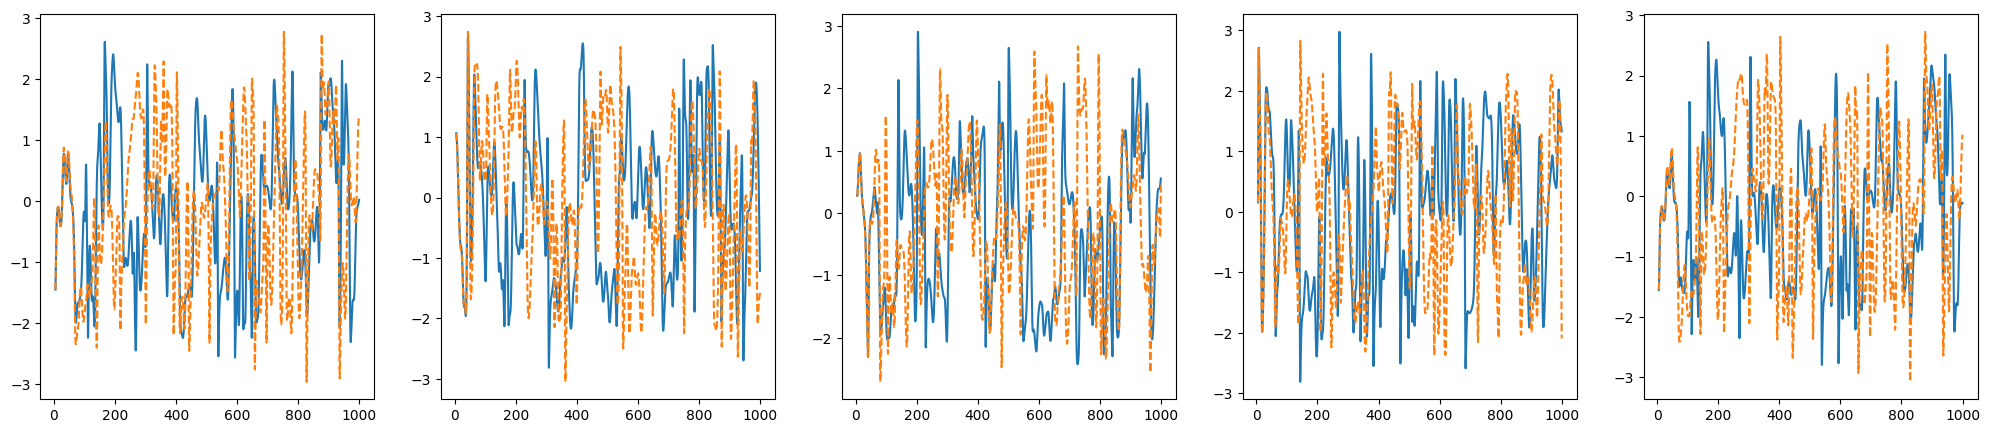

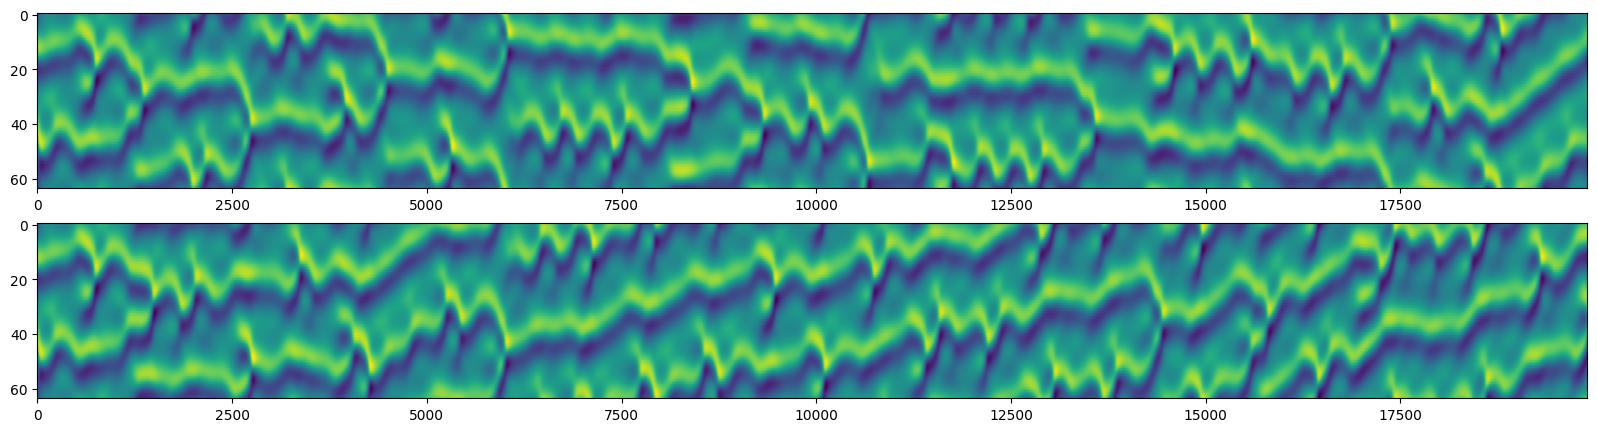

In [26]:
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=EPISODE_DATA['loop_0']['u_washout'], 
                                                 P_washout=EPISODE_DATA['loop_0']['p_washout'],
                                                 P = EPISODE_DATA['loop_0']['p'],
                                                 N_t=len(EPISODE_DATA['loop_0']['u']))
y_pred = y_pred[1:]
plt_idxs = [int(my_idx) for my_idx in np.linspace(0,my_ESN.N_dim-1,5)]
plt.figure(figsize=(5*len(plt_idxs),5))
for k, plt_idx in enumerate(plt_idxs):
    plt.subplot(1,len(plt_idxs),k+1)
    plt.plot(EPISODE_DATA['loop_0']['t'],EPISODE_DATA['loop_0']['y'][:,plt_idx])
    plt.plot(EPISODE_DATA['loop_0']['t'],y_pred[:,plt_idx],'--')
    # plt.xlim([0,500])
plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.imshow(EPISODE_DATA['loop_0']['y'].T, aspect='auto')
plt.subplot(2,1,2)
plt.imshow(y_pred.T, aspect='auto')

if which_state == 'pod_time_coeff':
    recon_y = my_POD.reconstruct(which_modes=which_modes,
                        A=EPISODE_DATA['loop_0']['y'],
                    )
    recon_y_pred = my_POD.reconstruct(which_modes=which_modes,
                        A=y_pred,
                    )

    plt.figure(figsize=(20,10), constrained_layout=True)
    plt.subplot(5,1,1)
    plt.imshow(EPISODE_DATA['loop_0']['full_state'].T, aspect='auto')
    plt.title(f'True')
    plt.colorbar()
    plt.subplot(5,1,2)
    plt.imshow(recon_y, aspect='auto')
    plt.title(f'True Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,3)
    plt.imshow(recon_y_pred, aspect='auto')
    plt.title(f'Prediction Reduced N = {which_modes}')
    plt.colorbar()
    plt.subplot(5,1,4)
    plt.imshow(EPISODE_DATA['loop_0']['full_state'].T-recon_y_pred, aspect='auto')
    plt.title('Error')
    plt.colorbar()
    plt.subplot(5,1,5)
    plt.imshow(recon_y-recon_y_pred, aspect='auto')
    plt.title('Error Reduced')
    plt.colorbar()
    plt.show()

In [27]:
# jit the necessary environment functions
env_draw_initial_condition = partial(
    draw_initial_condition,
    std_init=config.enKF.std_init,
)
env_draw_initial_condition = jax.jit(env_draw_initial_condition)

env_reset = partial(
    KSenv.reset,
    N=env.N,
    B=env.ks_solver.B,
    lin=env.ks_solver.lin,
    ik=env.ks_solver.ik,
    dt=env.ks_solver.dt,
    initial_amplitude=env.initial_amplitude,
    action_size=env.action_size,
    burn_in=env.burn_in,
    observation_inds=env.observation_inds,
)

# reset the environment
key_env, key_ens, key_init = jax.random.split(key_env, 3)
init_true_state_mean, _, _ = env_reset(key=key_env)
init_true_state = env_draw_initial_condition(
    u0=init_true_state_mean, key=key_init
)
init_true_obs = init_true_state[env.observation_inds]

init_reward = jnp.nan

In [28]:
def initialize_ensemble_with_washout(my_ESN, U_washout, P_washout, std_init, m, key):
    # initialize an ensemble of ESNs 
    r0 = my_ESN.run_washout(U_washout, P_washout)

    # create an ensemble by perturbing the reservoir state
    key, subkey = jax.random.split(key)

    r0_ens = jax.random.multivariate_normal(
        key,
        r0,
        jnp.diag((r0 * std_init) ** 2),
        (m,),
        method="svd",
    ).T

    return r0_ens

# initialize enKF
std_init = 0.05
m = 50
init_state_ens = initialize_ensemble_with_washout(my_ESN=my_ESN, 
                                                  U_washout=DATA['train']['u_washout'][episode_idx], 
                                                  P_washout=DATA['train']['p_washout'][episode_idx], 
                                                  std_init=std_init,
                                                  m=m,
                                                  key=key_ens)

In [60]:
def get_observation_matrix(my_ESN, observation_indices):
    """
    Create an observation matrix for the given ESN based on observation indices.
    """
    # Initialize a zero matrix with appropriate dimensions
    M = jnp.zeros((len(observation_indices), my_ESN.W_out.T.shape[0]))
    
    # Set the appropriate entries to 1 based on observation_indices
    M = M.at[jnp.arange(len(observation_indices)), observation_indices].set(1)
    
    # Multiply with the transposed output weight matrix and return
    return M @ my_ESN.W_out[:-len(my_ESN.output_bias)].T

In [61]:
M = get_observation_matrix(my_ESN, env.observation_inds)

In [63]:
def EnKF(m, Af, d, Cdd, M, key):
    """Taken from real-time-bias-aware-DA by Novoa.
    Ensemble Kalman Filter as derived in Evensen book (2009) eq. 9.27.
    Inputs:
        Af: forecast ensemble at time t
        d: observation at time t
        Cdd: observation error covariance matrix
        M: matrix mapping from state to observation space
    Returns:
        Aa: analysis ensemble
    """
    psi_f_m = jnp.mean(Af, 1, keepdims=True)
    Psi_f = Af - psi_f_m

    # Create an ensemble of observations
    D = jax.random.multivariate_normal(key, d, Cdd, (m,), method="svd").T
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = jnp.real(jnp.dot(M, Af))
    S = jnp.real(jnp.dot(M, Psi_f))
    # because we are multiplying with M first, we get real values
    # so we never actually compute the covariance of the complex-valued state
    # if i have to do that, then make sure to do it properly with the complex conjugate!!
    # Matrix to invert
    C = (m - 1) * Cdd + jnp.dot(S, S.T)
    # Cinv = jnp.linalg.inv(C)

    # X = jnp.dot(S.T, jnp.dot(Cinv, (D - Y)))
    X = jnp.dot(S.T, jnp.linalg.solve(C, D - Y))

    Aa = Af + jnp.dot(Af, X)
    # Aa = Af + jnp.dot(Psi_f, X) # gives same result as above
    return Aa

In [116]:
# forecast
forecast_ens = np.zeros((my_ESN.N_reservoir,m))
init_state_ens = np.asarray(init_state_ens)

for i in range(m):
    forecast_ens[:,i] = my_ESN.closed_loop(x0=init_state_ens[:,i],N_t=1,P=DATA['train']['p'][episode_idx])[0][1]

true_obs = DATA['train']['full_state'][episode_idx][0][env.observation_inds]
std_obs = 0.05
obs_cov = cov.get_max(std=std_obs, y=true_obs)

# add noise on the observation
key_obs, key_enKF = jax.random.split(key_obs)
obs = jax.random.multivariate_normal(
    key_obs, true_obs, obs_cov, method="svd"
)

# before readout
# if using r2 mode, we still want to the observation matrix to be linear
# so apply the before readout to the forecast state ensemble
forecast_ens_new = forecast_ens.copy()
if my_ESN.r2_mode == True:
    # get before readout
    forecast_ens_new[1::2] = forecast_ens_new[1::2] ** 2

# remove the bias from the data
bias = np.multiply(my_ESN.output_bias, my_ESN.W_out[-len(my_ESN.output_bias)])
obs_new = obs - bias[env.observation_inds]

analysed_ens_new = EnKF(m=m, Af=forecast_ens_new, d=obs_new, Cdd=obs_cov, M=M, key=key_enKF)

# adapt the analysed ensemble
analysed_ens = np.asarray(analysed_ens_new).copy()
if my_ESN.r2_mode == True:
    new_arr = np.maximum(analysed_ens[1::2], 0)
    analysed_ens[1::2] = np.sqrt(new_arr)

In [117]:
(my_ESN.before_readout(np.mean(forecast_ens,axis=1)) @ my_ESN.W_out)

array([ 0.14327622,  0.45421582,  0.80397002,  1.15679137,  1.47384479,
        1.7326456 ,  1.88221601,  1.83949031,  1.58846122,  1.16988757,
        0.58481539, -0.10321117, -0.75946486, -1.28438835, -1.63032181,
       -1.7790678 , -1.73887562, -1.54681671, -1.26419404, -0.95596265,
       -0.6579176 , -0.38351168, -0.14941814,  0.02086787,  0.13429025,
        0.21972109,  0.27879616,  0.3237977 ,  0.3845262 ,  0.47751051,
        0.61190421,  0.79783776,  1.03150514,  1.29120155,  1.55524322,
        1.78966172,  1.9560096 ,  2.01292326,  1.90586272,  1.60391897,
        1.12874512,  0.53627833, -0.10139997, -0.70615678, -1.18798619,
       -1.48564482, -1.60604242, -1.59006981, -1.47091494, -1.28175324,
       -1.08053202, -0.92043413, -0.80781649, -0.73311745, -0.70568344,
       -0.72680173, -0.76271274, -0.77831911, -0.76929609, -0.7361149 ,
       -0.66053839, -0.53047218, -0.35185619, -0.12671697])

In [118]:
(my_ESN.before_readout(np.mean(analysed_ens,axis=1)) @ my_ESN.W_out)

array([ 0.18617763,  0.46821196,  0.79906998,  1.16821925,  1.47429274,
        1.70155785,  1.83732357,  1.78961834,  1.53494281,  1.13652944,
        0.5725495 , -0.11029019, -0.76724942, -1.27826293, -1.59771097,
       -1.77764319, -1.77988126, -1.54339694, -1.24304272, -0.96788114,
       -0.66869791, -0.37750626, -0.1421249 ,  0.03125224,  0.14699179,
        0.2247863 ,  0.28718895,  0.34113695,  0.3864213 ,  0.46596652,
        0.62024151,  0.79532971,  0.99270958,  1.2739629 ,  1.54578209,
        1.76041393,  1.93336808,  1.9950096 ,  1.87942265,  1.59650513,
        1.14698784,  0.53642282, -0.1159395 , -0.70152676, -1.16950991,
       -1.47152677, -1.59534578, -1.57809941, -1.46256596, -1.27717961,
       -1.07499226, -0.92125125, -0.82923746, -0.7493192 , -0.68033436,
       -0.72812167, -0.82159015, -0.79351856, -0.76534974, -0.76582211,
       -0.67434102, -0.51714642, -0.35047757, -0.11381295])

In [119]:
DATA['train']['full_state'][episode_idx][0]

array([ 0.15236563,  0.47015971,  0.81574172,  1.16518538,  1.48625092,
        1.7367452 ,  1.86681435,  1.82912615,  1.59416031,  1.16271491,
        0.57313855, -0.09816665, -0.75071129, -1.28704673, -1.63884264,
       -1.78137811, -1.73476433, -1.54693368, -1.2712647 , -0.95894923,
       -0.65192355, -0.37788719, -0.15305906,  0.01588131,  0.13545908,
        0.21930934,  0.2779902 ,  0.32615771,  0.38583906,  0.47760059,
        0.61469494,  0.8005519 ,  1.0277478 ,  1.28095624,  1.54057676,
        1.77728485,  1.94811849,  2.00274414,  1.89739097,  1.60766903,
        1.13927827,  0.53915062, -0.10821239, -0.70586617, -1.17589205,
       -1.47586928, -1.60092498, -1.57794022, -1.45184152, -1.2716987 ,
       -1.08195889, -0.91610744, -0.79528268, -0.72850225, -0.71231276,
       -0.731127  , -0.76136498, -0.78072462, -0.7746839 , -0.73497818,
       -0.65428416, -0.52654727, -0.34935223, -0.12271721])